### 【問題1】コンペティション内容の確認
[コンペティション](https://www.kaggle.com/c/home-credit-default-risk)のOverviewページ読み、「Home Credit Default Risk」について以下の観点について確認してください。

1. 何を学習し、何を予測するのか
2. どのようなファイルを作りKaggleに提出するか
3. 提出されたものはどういった指標値で評価されるのか

1. コンペのTARGET以外の説明データを学習し、TARGETを0か1かで予測する。
2. 顧客IDに対するROC-AUCがをcsvファイルを提出。
3. ROC-AUC(ROC曲線の下領域の面積)

### 【問題2】学習と検証
データを簡単に分析、前処理し、学習、検証するまでの一連の流れを作成・実行してください。

検証にはこのコンペティションで使用される評価指標を用いるようにしてください。学習に用いる手法は指定しません。

In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import scipy
import missingno as msno
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from decimal import Decimal, ROUND_HALF_UP, ROUND_HALF_EVEN
import math

In [2]:
df_train = pd.read_csv("application_train.csv")
df_test = pd.read_csv("application_test.csv")

In [3]:
df_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


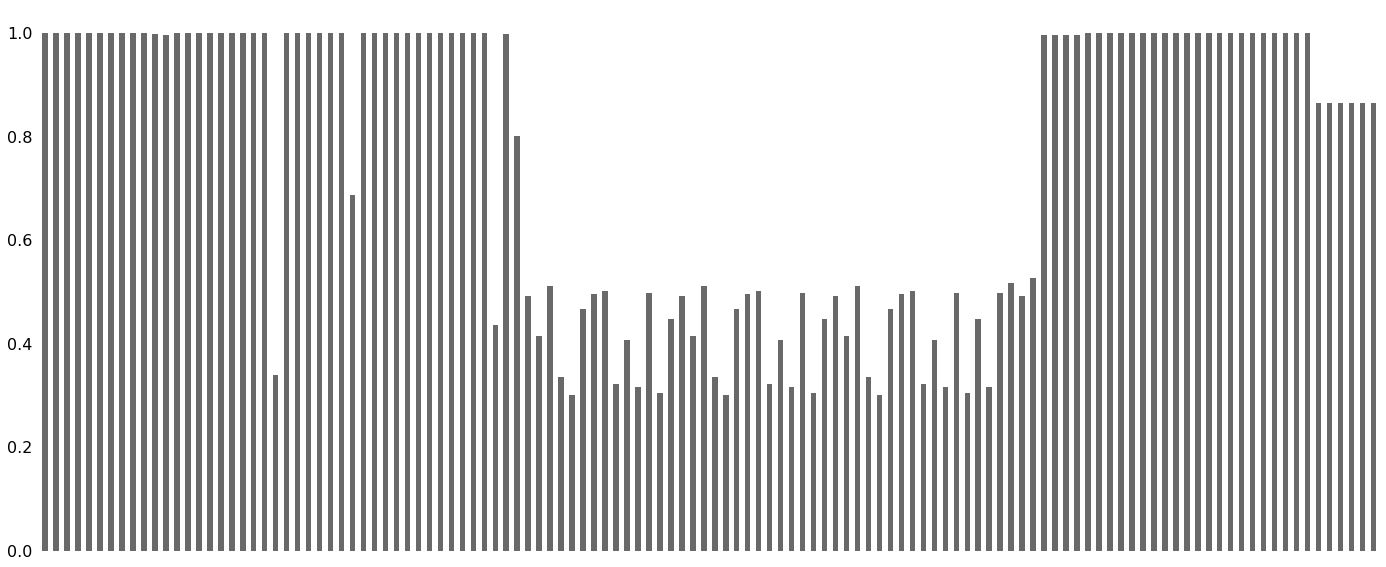

In [4]:
msno.bar(df_train)

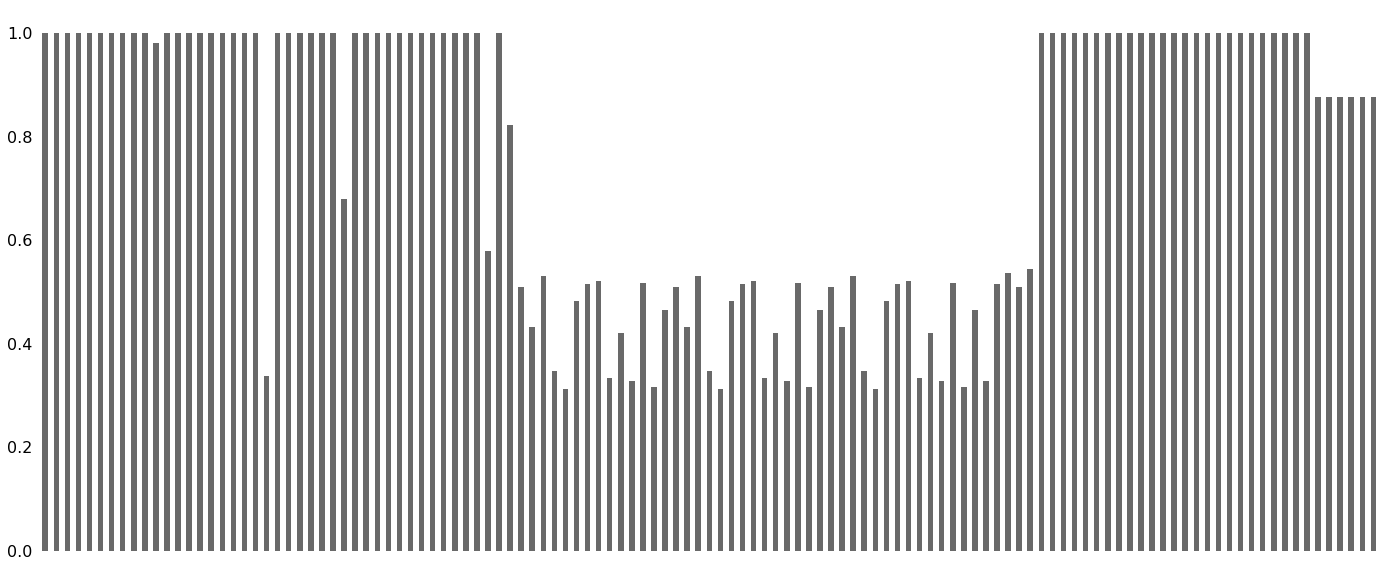

In [5]:
msno.bar(df_test)

1: 支払が困難なクライアント, 0:それ以外の場合


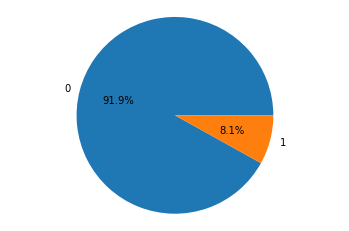

In [6]:
#ラベルごとのサンプル数を円グラフにする（パーセンテージまで表示する）

print("1: 支払が困難なクライアント, 0:それ以外の場合")

plt.pie(df_train["TARGET"].value_counts(), labels=['0', '1'], autopct="%1.1f%%")
plt.axis('equal') #真円に

plt.show()

In [7]:
columns = df_train.columns
list_drop = []

for i, column in enumerate(columns):
    if df_train.iloc[:, i].isnull().sum()/df_train.shape[0] >= 0.1:
        list_drop.append(column)
        
df_train_drop = df_train.drop(columns=list_drop)

df_train_drop.shape

(307511, 65)

In [8]:
columns = df_test.columns
list_drop = []

for i, column in enumerate(columns):
    if df_test.iloc[:, i].isnull().sum()/df_test.shape[0] >= 0.1:
        list_drop.append(column)
        
df_test_drop = df_test.drop(columns=list_drop)

df_test_drop.shape

(48744, 64)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = df_train_drop[['CNT_CHILDREN', 'AMT_INCOME_TOTAL']]
y = df_train_drop['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=32)

In [10]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict_proba(X_test)
y_pred

array([[0.93240518, 0.06759482],
       [0.9423948 , 0.0576052 ],
       [0.87741518, 0.12258482],
       ...,
       [0.95037046, 0.04962954],
       [0.83755501, 0.16244499],
       [0.72791871, 0.27208129]])

In [11]:
from sklearn.metrics import roc_auc_score

score = roc_auc_score(y_test, y_pred[:, 1])
score

0.5199941908699295

### 【問題3】テストデータに対する推定
テストデータ（application_test.csv）に対して推定を行い、Kaggleに提出を行ってください。

正しく提出が行えていれば、精度は低くても構いません。

In [12]:
df_test_2 = df_test[['CNT_CHILDREN', 'AMT_INCOME_TOTAL']]

y_pred_sub = lr.predict_proba(df_test_2)
y_pred_sub[:, 1]

array([0.12258482, 0.19103023, 0.04962954, ..., 0.04962954, 0.03625341,
       0.12258482])

In [13]:
score_submit = pd.concat([df_test['SK_ID_CURR'], pd.Series(y_pred_sub[:, 1])], axis=1)
score_submit = score_submit.rename(columns={0: 'TARGET'})
score_submit

,SK_ID_CURR,TARGET
0,100001,0.122585
1,100005,0.191030
2,100013,0.049630
3,100028,0.010027
4,100038,0.067595
...,...,...
48739,456221,0.145373
48740,456222,0.091438
48741,456223,0.049630
48742,456224,0.036253


In [14]:
score_submit.to_csv('kaggle.csv', index=False)

### 【問題4】特徴量エンジニアリング
精度を上げるために以下のような観点で 特徴量エンジニアリング（Feature Engineering） を行ってください。

どの特徴量を使うか
どう前処理をするか

何をした時に検証データに対する評価指標がどのようになったかをまとめてください。最低5パターンの学習・検証を行ってください。


精度が高かったものに関してはテストデータに対しても推定を行い、Kaggleに提出を行ってください。

#### 特徴量エンジニアリングで試すこと(5パターンの検証に向けて)
以下について、一つ試す度に学習・検証を実施する。全く前処理がされていない状態のデータからスタートする。

1. 欠損値に関する前処理を実施
   - 欠損率が比較的高いカラムの削除
   - 欠損値の補完
2. 名義尺度・順序尺度でデータを持っているカラムについてエンコーディングを実施
   - 名義尺度→one-hot表現(※最初から0 or 1でデータを持っているものもあるので注意する) 
   - 順序尺度→数値化
3. 相関係数を考慮し、特徴量の選択を実施(※わからないことが多いのでメモ書き)
   - 重要度とは?
   - 目的変数との相関の有無を先に見るべきか、重要度を先に見るべきか(Kaggleノートブックで参考になるものがないかどうか見る)
   - 次元の削減方法
     - 正則化項を導入
     - t検定による特徴量の選択
4. 3.で選択した特徴量の分布を見て、必要に応じて対数変換・スケーリングを実施する
5. 連続値でデータを持っているものについて離散値に変換する
6. モデルのパラメータを変えながら検証する
7. クロスバリデーションでの学習を考慮する

本来であれば1〜7の操作の組み合わせを考慮して色々試すべきなのだろうが、今回は特徴量エンジニアリングの流れの学習のために順番に実施したら終わりとする。(今回、5.と7.はスキップする)

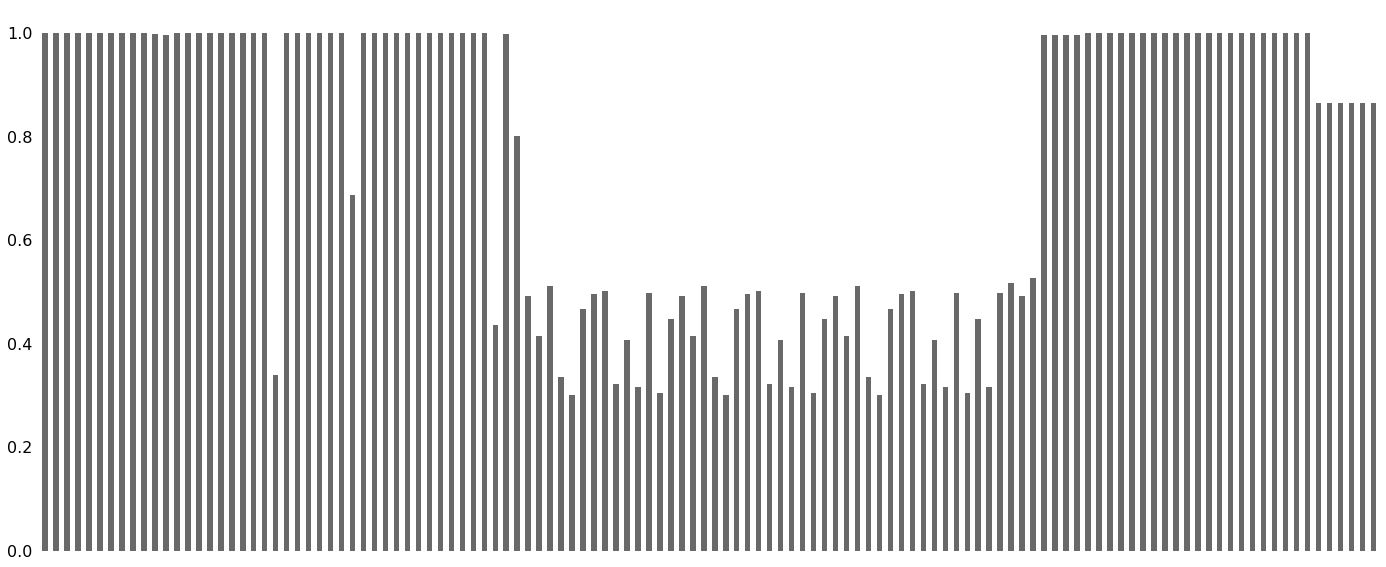

In [15]:
# 1. 欠損値に関する前処理を実施
## 欠損率が比較的高いカラムの削除

msno.bar(df_train)

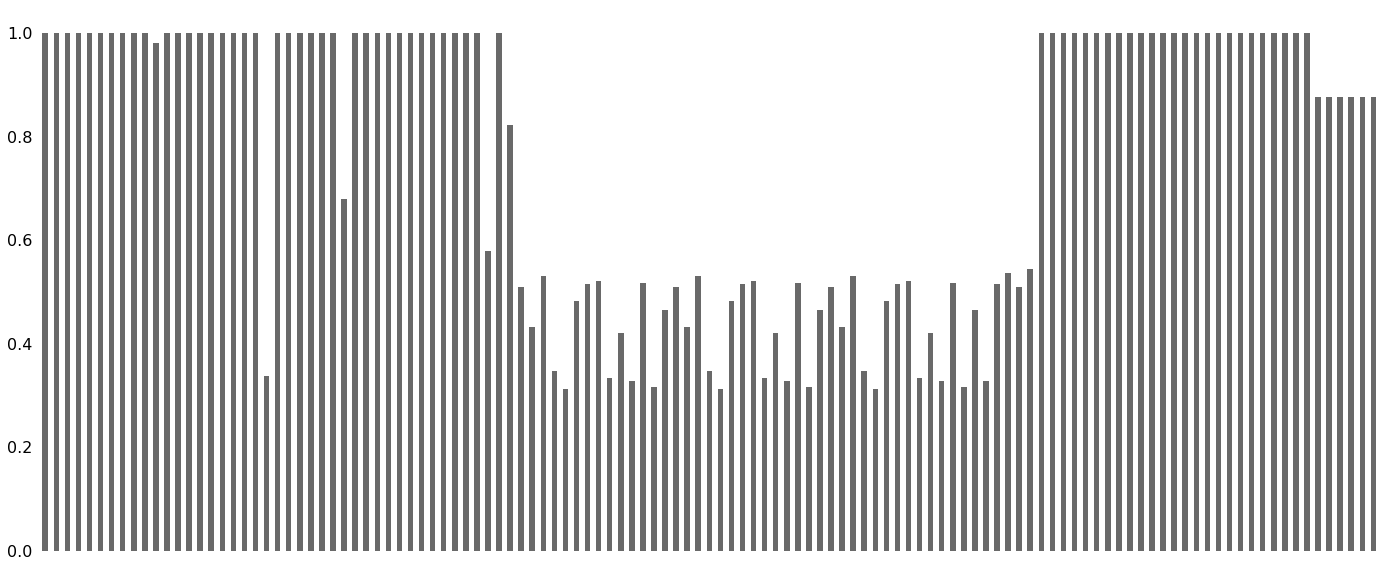

In [16]:
msno.bar(df_test)

In [17]:
def dropColumnsByDificitRate(df, rate=0.2):
    """
    欠損率がrate以上の列を削除したデータフレームを返却
    """    
    columns = df.columns
    list_drop = []

    for i, column in enumerate(columns):
        if df.iloc[:, i].isnull().sum()/df.shape[0] >= rate:
            list_drop.append(column)

    return df.drop(columns=list_drop)

In [18]:
df_train_drop = dropColumnsByDificitRate(df_train)
df_test_drop = dropColumnsByDificitRate(df_test)
print(df_train_drop.shape)
print(df_test_drop.shape)

(307511, 72)
(48744, 71)


In [19]:
# 欠損値の補完
df_train_drop = df_train_drop.fillna(df_train_drop.mean())
df_test_drop = df_test_drop.fillna(df_test_drop.mean())

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

knc = KNeighborsClassifier()
lr = LogisticRegression(max_iter=1000) # max_iterがデフォルトだと収束に関する警告が出る
svc = SVC()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

dict_model = {
              "KNeighborsClassifier":knc,
              "LogisticRegression":lr,
#              "SVC":svc,
              "DecisionTreeClassifier":dt,
              "RandomForestClassifier":rf
             }

In [21]:
def dataSplit2calcScore(X, y, model, test_size=0.25, random_state=32):
    """
    [Input]
    X:特徴量(pandas.DataFrame)
    y:目的変数(pandas.DataFrame)
    model:sklearnの分類モデル
    test_size:train_test_splitのパラメータ
    random_state:train_test_splitのパラメータ
    [return]
    ROC-AUC
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size,
                                                        random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)
    return roc_auc_score(y_test, y_pred[:, 1])

In [22]:
df_train_drop.select_dtypes(include='object').columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE'],
      dtype='object')

In [23]:
list_feature_name = df_train_drop.columns.drop(['SK_ID_CURR', 'TARGET'])
list_feature_name = list_feature_name.drop(df_train_drop.select_dtypes(include='object').columns)

X = df_train_drop[list_feature_name]
y = df_train_drop['TARGET']

dict_score = {}
for name, model in dict_model.items():
    dict_score[name] = dataSplit2calcScore(X, y, model)

pd.DataFrame(dict_score.values(), index=dict_score.keys()).rename(columns={0: 'ROC-AUC'})

,ROC-AUC
KNeighborsClassifier,0.554994
LogisticRegression,0.618368
DecisionTreeClassifier,0.532484
RandomForestClassifier,0.706025


#### 結果( 1. 欠損値に関する前処理を実施)
１度目の実施結果として、欠損率が20%以上のカラム・データを文字列で持っているカラムを削除したもので学習・検証した。\
４つのモデルを使用したが、最も良い結果を出したのはランダムフォレストであった。\
2回目以降の操作で、各モデルで指標値がどのように変わっていくかを見ていく。

In [24]:
# 2. 名義尺度・順序尺度でデータを持っているカラムについてエンコーディングを実施
df_train_drop.select_dtypes(include='object').columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE'],
      dtype='object')

In [25]:
# 順序尺度か、名義尺度かの区別をする。(0:名義尺度、1:順序尺度)
dict_kind_column = {
    'NAME_CONTRACT_TYPE':0,
    'CODE_GENDER':0,
    'FLAG_OWN_CAR':0,
    'FLAG_OWN_REALTY':0,
    'NAME_TYPE_SUITE':0,
    'NAME_INCOME_TYPE':0,
    'NAME_EDUCATION_TYPE':1, # 学歴
    'NAME_FAMILY_STATUS':0,
    'NAME_HOUSING_TYPE':0,
    'WEEKDAY_APPR_PROCESS_START':0,
    'ORGANIZATION_TYPE':0
}

print(df_train_drop['NAME_EDUCATION_TYPE'].unique())

['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']


In [26]:
list_dict_map = [
    {
        'Secondary / secondary special':1,
        'Lower secondary':2,
        'Incomplete higher':3,
        'Higher education':4,
        'Academic degree':5
    }
]

In [27]:
## 順序尺度→数値化
## 名義尺度→one-hot表現(※最初から0 or 1でデータを持っているものもあるので注意する)
def trans_qualitative(df, dict_kind_column, list_dict_map=None):
    """
    [INPUT]
    df:データフレーム
    dict_kind_column:キーにカラム名、値に区別が設定された辞書型。(0:名義尺度、1:順序尺度)
    [return]
    質的変数をエンコーディングしたpd.DataFrame
    """
    cnt = 0
    df_tmp = df.copy()
    
    for name, value in dict_kind_column.items():
        if value == 0: # 名義尺度
            # 少しでも次元削減するためにdrop_firstを指定して列数を減らす
            df_dummy = pd.get_dummies(df_tmp[name], drop_first = True)
            # 同じ列名が入らないようにする
            for column in df_dummy.columns:
                df_dummy = df_dummy.rename(columns={column: name+"_"+column}) 
            df_tmp = pd.concat([df_tmp.drop([name], axis=1), df_dummy], axis=1)
        else: # 順序尺度
            if list_dict_map != None:
                df_tmp[name] = df_tmp[name].map(list_dict_map[cnt])
                cnt += 1
            else:
                print("[エラー]変換用の辞書がありません")
                return

    return df_tmp

In [28]:
df_train_encode = trans_qualitative(df_train_drop, dict_kind_column, list_dict_map)

In [29]:
print(df_train_drop.shape)
print(df_train_encode.shape)

(307511, 72)
(307511, 153)


In [30]:
list_feature_name = df_train_encode.columns.drop(['SK_ID_CURR', 'TARGET'])

X = df_train_encode[list_feature_name]
y = df_train_encode['TARGET']

dict_score = {}
for name, model in dict_model.items():
    dict_score[name] = dataSplit2calcScore(X, y, model)

pd.DataFrame(dict_score.values(), index=dict_score.keys()).rename(columns={0: 'ROC-AUC'})

,ROC-AUC
KNeighborsClassifier,0.554994
LogisticRegression,0.618376
DecisionTreeClassifier,0.540284
RandomForestClassifier,0.714264


#### 結果( 2. 名義尺度・順序尺度でデータを持っているカラムについてエンコーディングを実施)
再近傍法以外のモデルについて指標値が改善したが、改善幅はそれほど大きくないように思える。\
文字列でデータを持っている特徴量のエンコーディングは、精度向上に有効であるといえる。

In [31]:
# 3. 相関係数を考慮し、特徴量の選択を実施

##### 重要度とは
（[参考](https://yolo-kiyoshi.com/2019/09/16/post-1226/)）\
決定木アルゴリズムで使われるもの。\
その特徴量の分割がターゲットの分類にどれくらい寄与しているかを測る指標。\
ジニ不純度(Gini impurity)"$G(k)$"をもとに計算できる。

$$
G(k)=\sum_{i=1}^np(i)*(1-p(i))
$$

$G(k)$:あるノード k における不純度\
$n$:ターゲットラベルの数\
$p(i)$:あるノード$k$におけるターゲットラベル$i$の頻度

ノードにおいて完全にサンプルが分類されている場合はジニ不純度は0になる。\
ジニ不純度(Gini impurity)をもとに重要度(importance)が計算される。\
重要度は「ある特徴量で分割することでどれくらいジニ不純度を下げられるのか」を意味している。

$$
I(j)=\sum_{i=1}^{n\in{F(j)}}(N_{parent}(i)*G_{parent}(i))-(N_{left\_child}(i)*G_{left\_child}(i)+N_{right\_child}(i)*G_{right\_child}(i))
$$

$I(j)$:ある特徴量jにおける重要度\
$F(j)$:ある特徴量$j$が分割対象となるノードの集合\
$N_{parent}(i)$:あるノード$i$におけるサンプル数\
$N_{left\_child}(i)$:あるノード$i$の子のうち左側のノードのサンプル数\
$N_{right\_child}(i)$:あるノード$i$の子のうち右側のノードのサンプル数\
$G_{parent}(i)$:あるノード$i$におけるジニ不純度\
$G_{left\_child}(i)$:あるノード$i$の子ノードのうち左側のノードにおけるジニ不純度\
$G_{right\_child}(i)$:あるノード$i$の子ノードのうち右側のノードにおけるジニ不純度

決定木は集められたデータをなるべく綺麗にラベル分類する特徴量と閾値の選択を、連続して行っている。\
構築済の木を見て、それぞれの特徴量による枝分かれでジニ不純度(分割によって各ラベルがサンプルに混ざっている具合。ジニ不純度の導出式からも分かるように、ラベルが綺麗に分割されると0になる。)が下げられるかどうかの指標値として、重要度が用いられている。大きいほど、その特徴量は重要であると示せる。

##### 目的変数との相関の有無を先に見るべきか、重要度を先に見るべきか(Kaggleノートブックで参考になるものがないかどうか見る)
[(参照1)](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction)[(参照2)](https://www.kaggle.com/codename007/home-credit-complete-eda-feature-importance)

どちらを先に観測したほうが良いという正解は無さそう。\
特徴量が量的変数・質的変数かで特徴量を選択するまでの判断方法が異なるため、まずはデータを図示して見てみるべき。

- 量的変数はランダムフォレストの重要度を見てみるのが最も手っ取り早い。特徴量の生成をするなどの兼ね合いで実施するタイミングを考慮しなければならないことに注意したい。
- データを観測する切り口は考えなければならない。(例：質的変数で名義尺度と見るべきと思われるデータでも、それぞれの値の個数をラベルごとに出してみる。ラベルで相関が見られるようであれば、特徴量をone-hot化したものを使用する)
- Kaggleで学んだことは、ここに追記していく。

##### 次元の削減方法
- 単純に特徴量の列を抜きだす
- 正則化項を導入
- t検定により特徴量を選択

In [32]:
feature_importance_values = rf.feature_importances_
domain_features_names = df_train_encode.columns.drop(['SK_ID_CURR', 'TARGET'])
feature_importance = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values})

In [33]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:20]))), 
            df['importance_normalized'].head(20), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:20]))))
    ax.set_yticklabels(df['feature'].head(20))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return list(df['feature'].head(20).values)


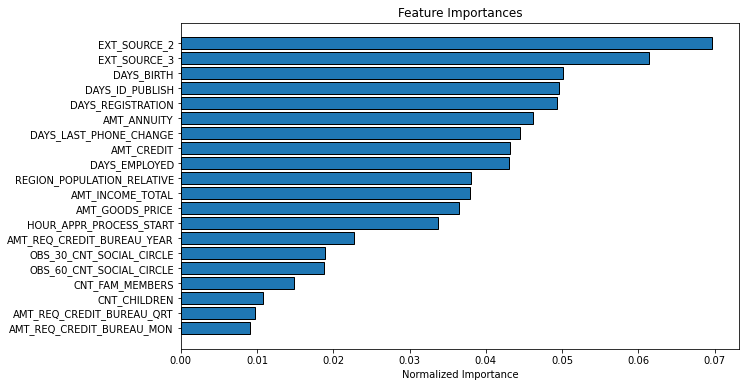

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'DAYS_ID_PUBLISH',
 'DAYS_REGISTRATION',
 'AMT_ANNUITY',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_CREDIT',
 'DAYS_EMPLOYED',
 'REGION_POPULATION_RELATIVE',
 'AMT_INCOME_TOTAL',
 'AMT_GOODS_PRICE',
 'HOUR_APPR_PROCESS_START',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'CNT_FAM_MEMBERS',
 'CNT_CHILDREN',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_MON']

In [34]:
list_selected_feature = plot_feature_importances(feature_importance)
list_selected_feature

In [35]:
df_train_select1 = pd.concat([df_train_encode[['SK_ID_CURR', 'TARGET']], df_train_encode[list_selected_feature]], axis=1)
df_train_select1

,SK_ID_CURR,TARGET,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_REGISTRATION,AMT_ANNUITY,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT,...,AMT_INCOME_TOTAL,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,AMT_REQ_CREDIT_BUREAU_YEAR,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,CNT_FAM_MEMBERS,CNT_CHILDREN,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_MON
0,100002,1,0.262949,0.139376,-9461,-2120,-3648.0,24700.5,-1134.0,406597.5,...,202500.0,351000.0,10,1.000000,2.0,2.0,1.0,0,0.000000,0.000000
1,100003,0,0.622246,0.510853,-16765,-291,-1186.0,35698.5,-828.0,1293502.5,...,270000.0,1129500.0,11,0.000000,1.0,1.0,2.0,0,0.000000,0.000000
2,100004,0,0.555912,0.729567,-19046,-2531,-4260.0,6750.0,-815.0,135000.0,...,67500.0,135000.0,9,0.000000,0.0,0.0,1.0,0,0.000000,0.000000
3,100006,0,0.650442,0.510853,-19005,-2437,-9833.0,29686.5,-617.0,312682.5,...,135000.0,297000.0,17,1.899974,2.0,2.0,2.0,0,0.265474,0.267395
4,100007,0,0.322738,0.510853,-19932,-3458,-4311.0,21865.5,-1106.0,513000.0,...,121500.0,513000.0,11,0.000000,0.0,0.0,1.0,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0.681632,0.510853,-9327,-1982,-8456.0,27558.0,-273.0,254700.0,...,157500.0,225000.0,15,1.899974,0.0,0.0,1.0,0,0.265474,0.267395
307507,456252,0,0.115992,0.510853,-20775,-4090,-4388.0,12001.5,0.0,269550.0,...,72000.0,225000.0,8,1.899974,0.0,0.0,1.0,0,0.265474,0.267395
307508,456253,0,0.535722,0.218859,-14966,-5150,-6737.0,29979.0,-1909.0,677664.0,...,153000.0,585000.0,9,1.000000,6.0,6.0,1.0,0,0.000000,1.000000
307509,456254,1,0.514163,0.661024,-11961,-931,-2562.0,20205.0,-322.0,370107.0,...,171000.0,319500.0,9,0.000000,0.0,0.0,2.0,0,0.000000,0.000000


In [36]:
df_train_select2 = pd.concat([df_train_encode[['SK_ID_CURR', 'TARGET']], 
                              df_train_encode.loc[:, df_train_encode.columns.str.startswith('ORGANIZATION_TYPE')]],
                             axis=1)
df_train_select2

,SK_ID_CURR,TARGET,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,100002,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
307507,456252,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
307508,456253,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
307509,456254,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
df_train_select2.drop(['SK_ID_CURR', 'TARGET'], axis=1).sum()

ORGANIZATION_TYPE_Agriculture                2454
ORGANIZATION_TYPE_Bank                       2507
ORGANIZATION_TYPE_Business Entity Type 1     5984
ORGANIZATION_TYPE_Business Entity Type 2    10553
ORGANIZATION_TYPE_Business Entity Type 3    67992
ORGANIZATION_TYPE_Cleaning                    260
ORGANIZATION_TYPE_Construction               6721
ORGANIZATION_TYPE_Culture                     379
ORGANIZATION_TYPE_Electricity                 950
ORGANIZATION_TYPE_Emergency                   560
ORGANIZATION_TYPE_Government                10404
ORGANIZATION_TYPE_Hotel                       966
ORGANIZATION_TYPE_Housing                    2958
ORGANIZATION_TYPE_Industry: type 1           1039
ORGANIZATION_TYPE_Industry: type 10           109
ORGANIZATION_TYPE_Industry: type 11          2704
ORGANIZATION_TYPE_Industry: type 12           369
ORGANIZATION_TYPE_Industry: type 13            67
ORGANIZATION_TYPE_Industry: type 2            458
ORGANIZATION_TYPE_Industry: type 3           3278


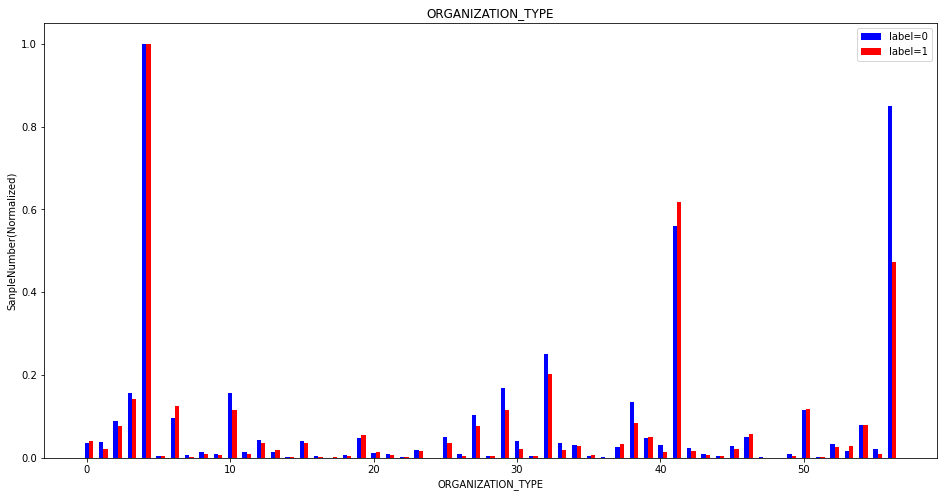

In [38]:
target_0 = df_train_select2.query("TARGET==0").drop(['SK_ID_CURR', 'TARGET'], axis=1).sum()
target_1 = df_train_select2.query("TARGET==1").drop(['SK_ID_CURR', 'TARGET'], axis=1).sum()

target_0 /= target_0.max()
target_1 /= target_1.max()

x1 = np.array(range(len(df_train_select2.drop(['SK_ID_CURR', 'TARGET'], axis=1).columns)))
x2 = np.array(range(len(df_train_select2.drop(['SK_ID_CURR', 'TARGET'], axis=1).columns))).astype("float64")
x2 += 0.3

plt.figure(figsize=(16, 8))
plt.title("ORGANIZATION_TYPE")
plt.xlabel("ORGANIZATION_TYPE")
plt.ylabel("SanpleNumber(Normalized)")

plt.bar(x1, target_0, color='b', width=0.3, label='label=0', align="center")
plt.bar(x2, target_1, color='r', width=0.3, label='label=1', align="center")

plt.legend()


職場別に見てみたが、分布にラベルとの相関はあまり無さそう。
試しに他の名義尺度のグラフについて全て表示してみる。

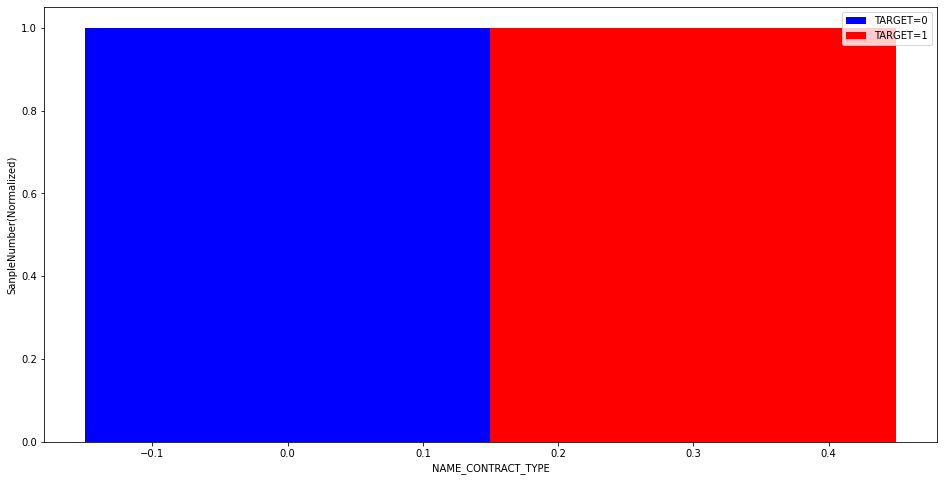

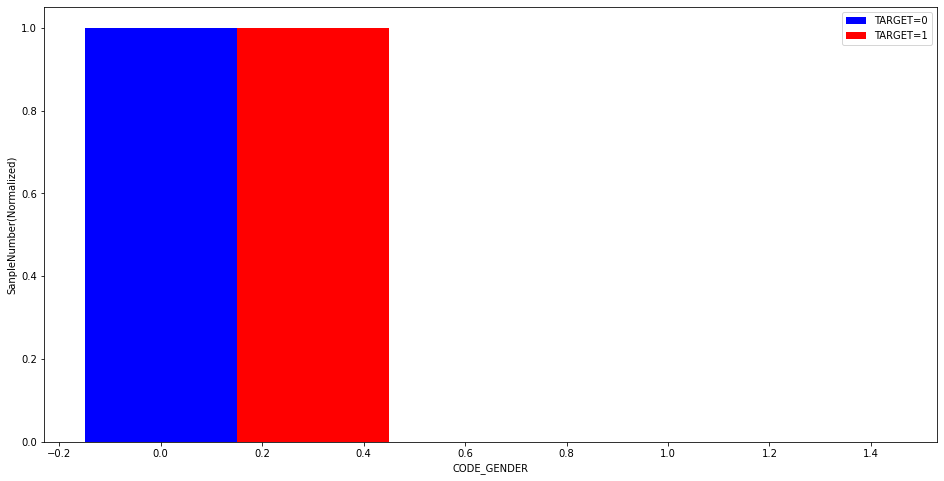

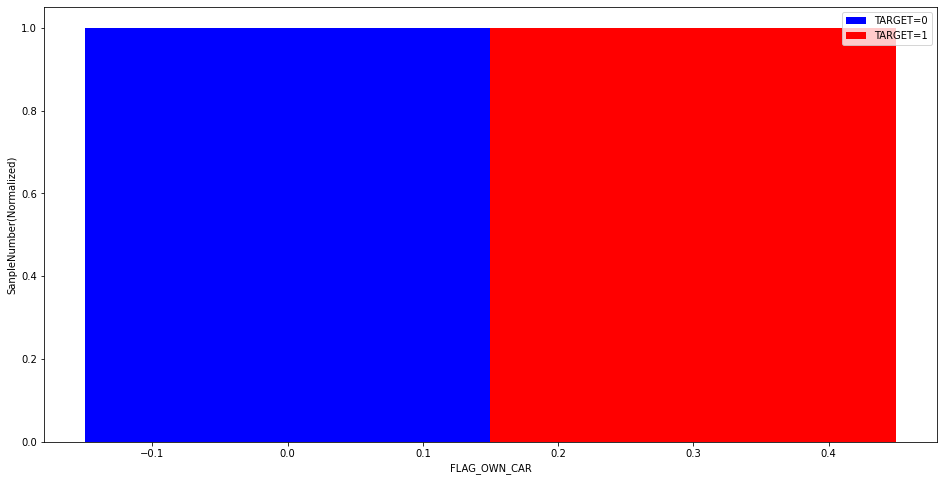

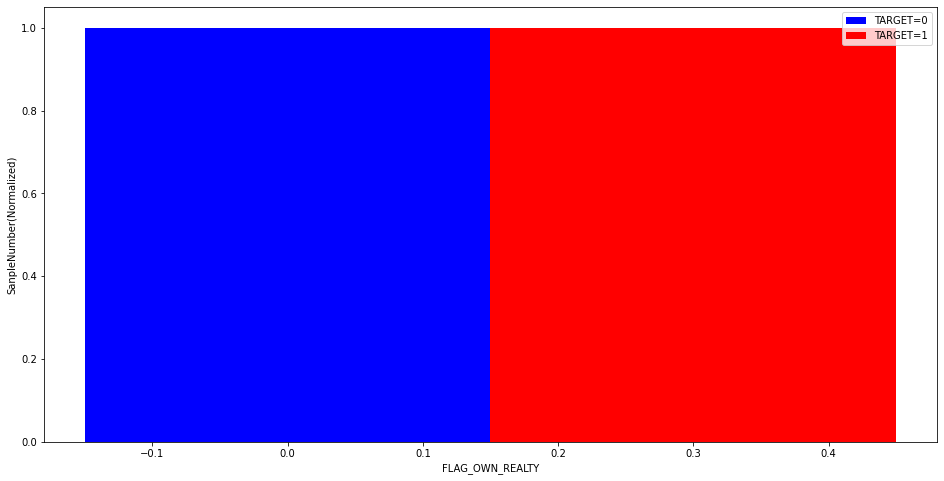

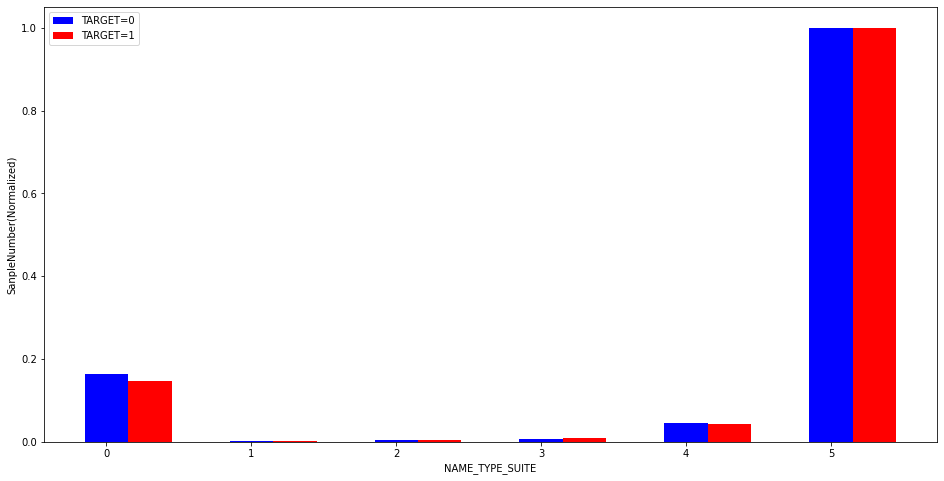

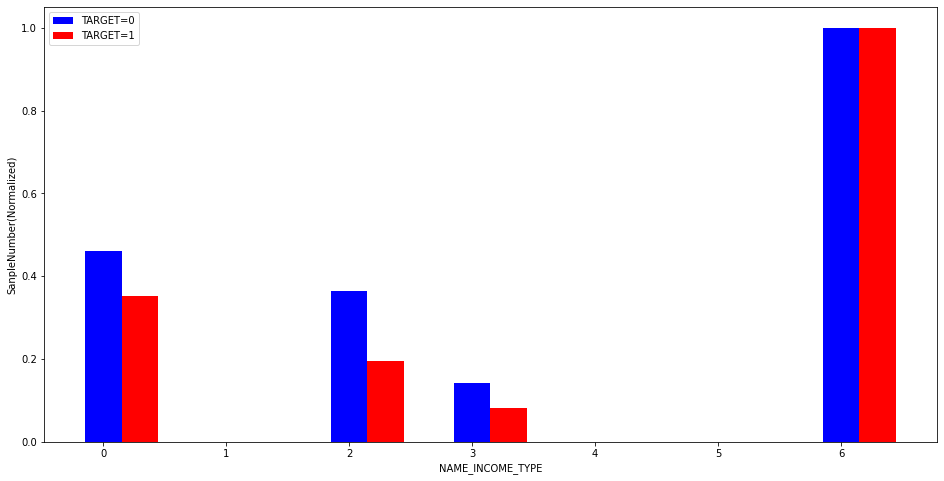

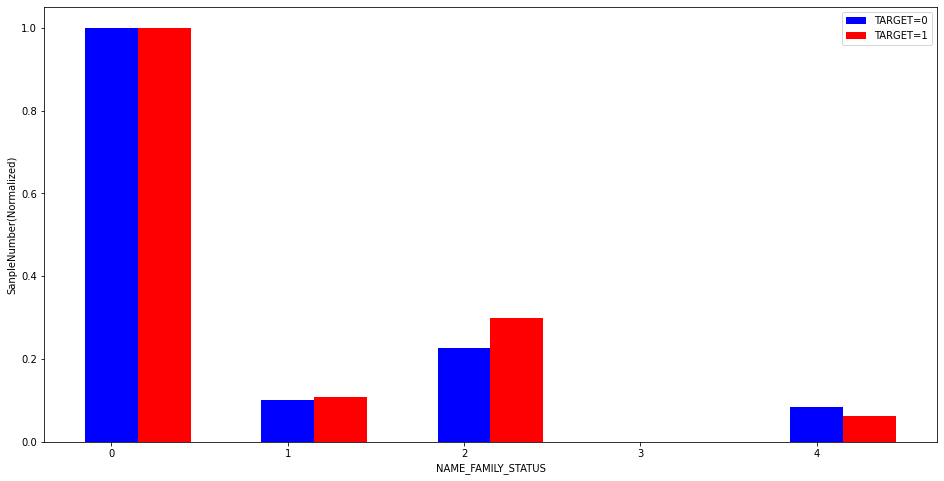

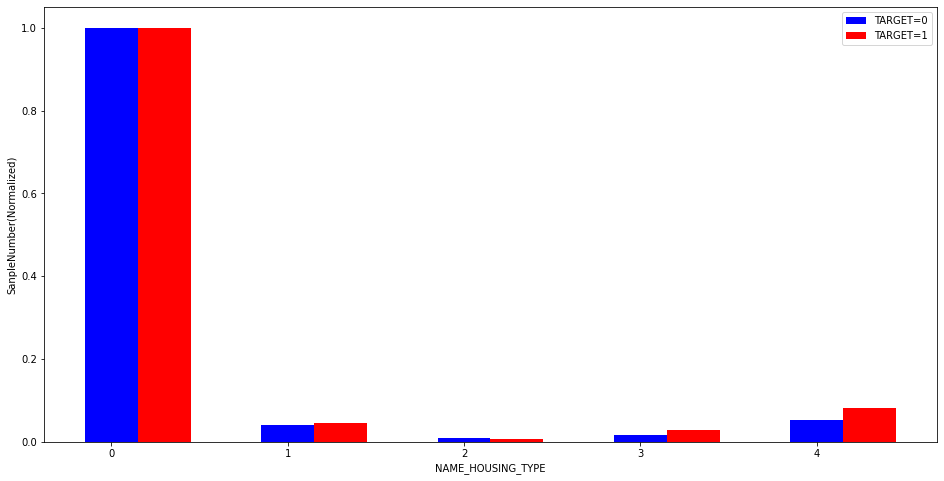

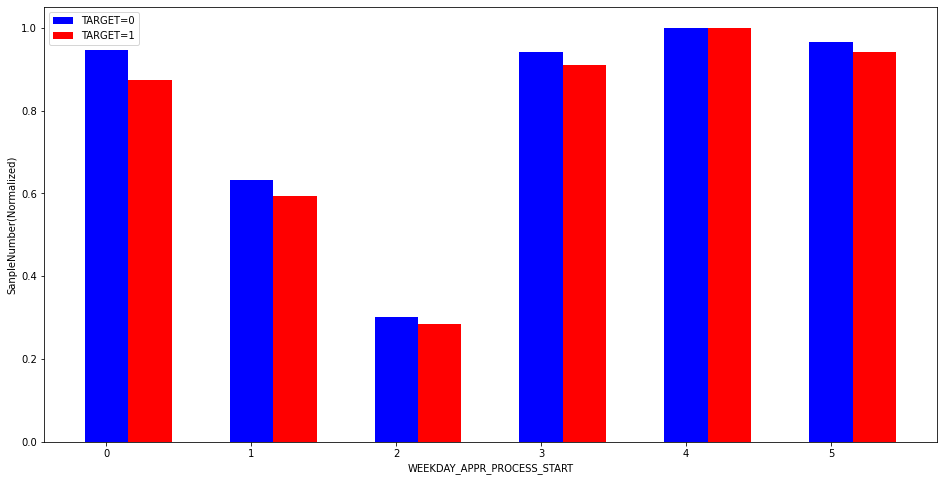

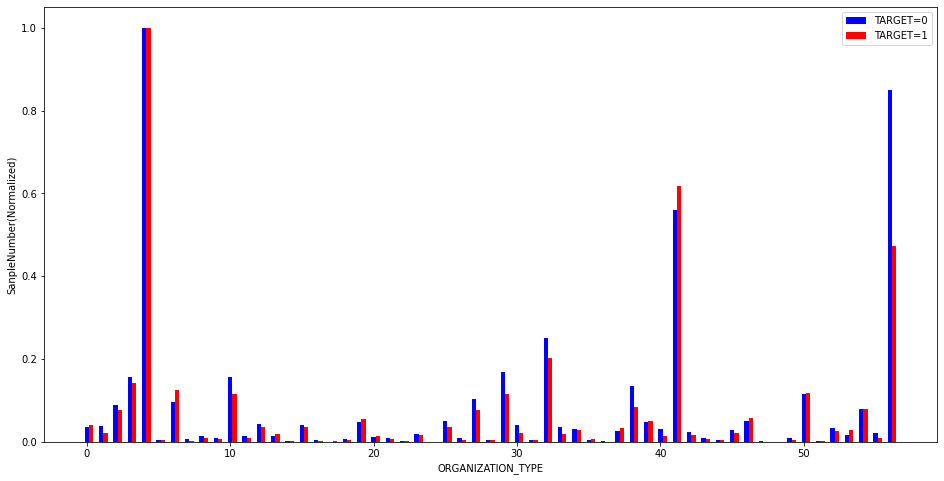

In [39]:
for key, value in dict_kind_column.items():
    if value == 0:
        df_train_select_tmp = pd.concat([df_train_encode[['SK_ID_CURR', 'TARGET']], 
                                        df_train_encode.loc[:, df_train_encode.columns.str.startswith(key)]],
                                        axis=1)        
        
        target_0 = df_train_select_tmp.query("TARGET==0").drop(['SK_ID_CURR', 'TARGET'], axis=1).sum()
        target_1 = df_train_select_tmp.query("TARGET==1").drop(['SK_ID_CURR', 'TARGET'], axis=1).sum()

        target_0 /= target_0.max()
        target_1 /= target_1.max()

        x1 = np.array(range(len(df_train_select_tmp.drop(['SK_ID_CURR', 'TARGET'], axis=1).columns)))
        x2 = np.array(range(len(df_train_select_tmp.drop(['SK_ID_CURR', 'TARGET'], axis=1).columns))).astype("float64")
        x2 += 0.3

        plt.figure(figsize=(16, 8))
        plt.xlabel(key)
        plt.ylabel("SanpleNumber(Normalized)")

        plt.bar(x1, target_0, color='b', width=0.3, label='TARGET=0', align="center")
        plt.bar(x2, target_1, color='r', width=0.3, label='TARGET=1', align="center")

        plt.legend()


収入のタイプに少し相関がありそうなので、特徴量として選んでみる。最終的にdf_train_select1と合わせたもので学習・検証する。

In [40]:
df_train_select3 = pd.concat([df_train_select1, 
                             df_train_encode.loc[:, df_train_encode.columns.str.startswith('NAME_INCOME_TYPE')]],
                             axis=1)
df_train_select3

,SK_ID_CURR,TARGET,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_REGISTRATION,AMT_ANNUITY,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT,...,CNT_CHILDREN,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_MON,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working
0,100002,1,0.262949,0.139376,-9461,-2120,-3648.0,24700.5,-1134.0,406597.5,...,0,0.000000,0.000000,0,0,0,0,0,0,1
1,100003,0,0.622246,0.510853,-16765,-291,-1186.0,35698.5,-828.0,1293502.5,...,0,0.000000,0.000000,0,0,0,1,0,0,0
2,100004,0,0.555912,0.729567,-19046,-2531,-4260.0,6750.0,-815.0,135000.0,...,0,0.000000,0.000000,0,0,0,0,0,0,1
3,100006,0,0.650442,0.510853,-19005,-2437,-9833.0,29686.5,-617.0,312682.5,...,0,0.265474,0.267395,0,0,0,0,0,0,1
4,100007,0,0.322738,0.510853,-19932,-3458,-4311.0,21865.5,-1106.0,513000.0,...,0,0.000000,0.000000,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0.681632,0.510853,-9327,-1982,-8456.0,27558.0,-273.0,254700.0,...,0,0.265474,0.267395,0,0,0,0,0,0,1
307507,456252,0,0.115992,0.510853,-20775,-4090,-4388.0,12001.5,0.0,269550.0,...,0,0.265474,0.267395,0,0,1,0,0,0,0
307508,456253,0,0.535722,0.218859,-14966,-5150,-6737.0,29979.0,-1909.0,677664.0,...,0,0.000000,1.000000,0,0,0,0,0,0,1
307509,456254,1,0.514163,0.661024,-11961,-931,-2562.0,20205.0,-322.0,370107.0,...,0,0.000000,0.000000,1,0,0,0,0,0,0


In [41]:
list_feature_name = df_train_select3.columns.drop(['SK_ID_CURR', 'TARGET'])

X = df_train_select3[list_feature_name]
y = df_train_select3['TARGET']

dict_score = {}
for name, model in dict_model.items():
    dict_score[name] = dataSplit2calcScore(X, y, model)

pd.DataFrame(dict_score.values(), index=dict_score.keys()).rename(columns={0: 'ROC-AUC'})

,ROC-AUC
KNeighborsClassifier,0.554994
LogisticRegression,0.618385
DecisionTreeClassifier,0.531100
RandomForestClassifier,0.704115


#### 結果( 3. 相関係数を考慮し、特徴量の選択を実施)
指標値が全体的に僅かに下がった。\
特徴量を適切に選択することで、大幅に次元削減しても大きく指標値が下がらないことがわかった。

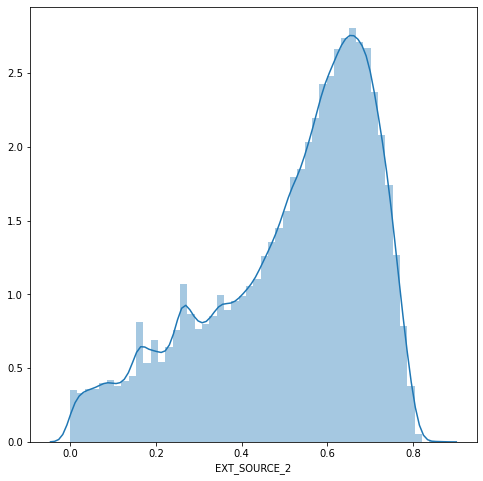

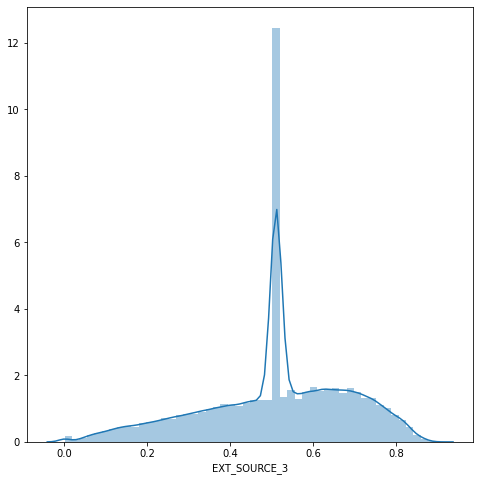

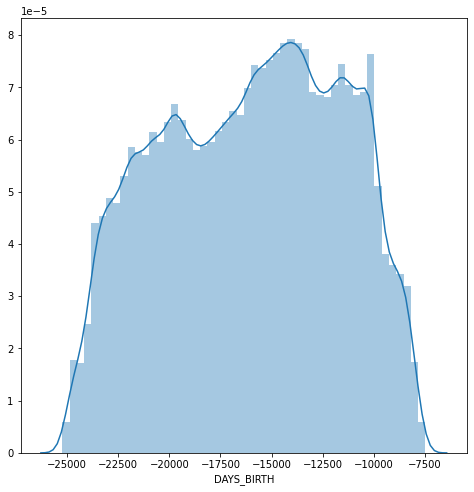

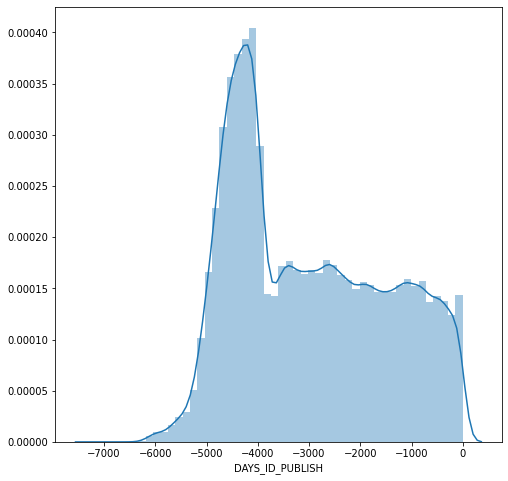

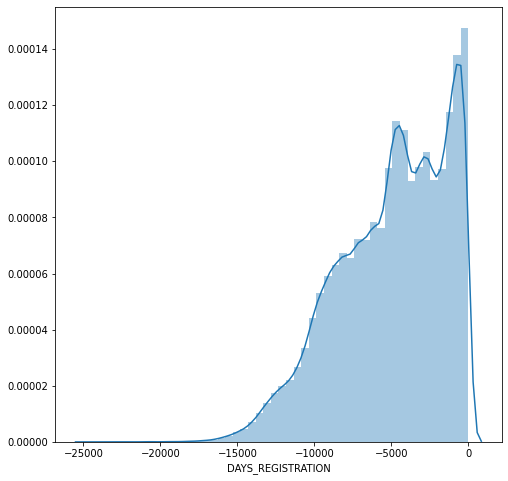

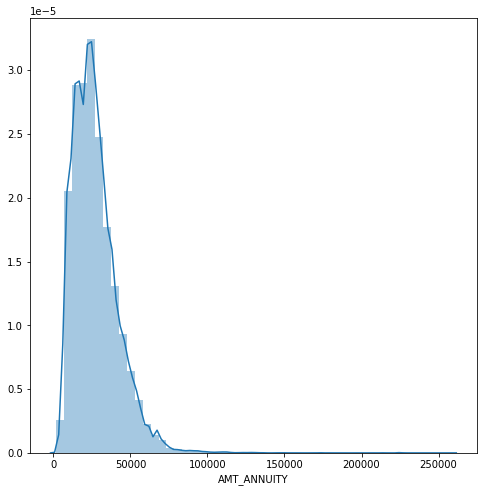

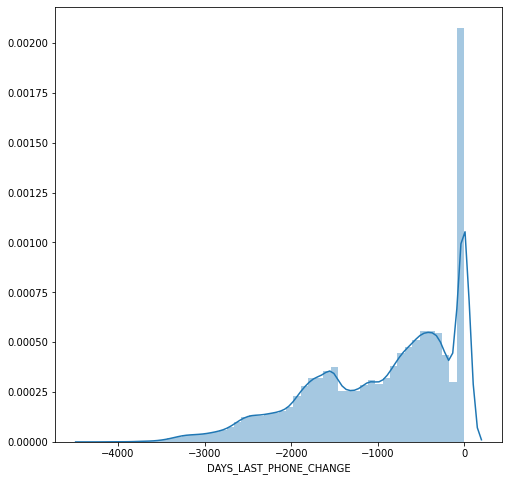

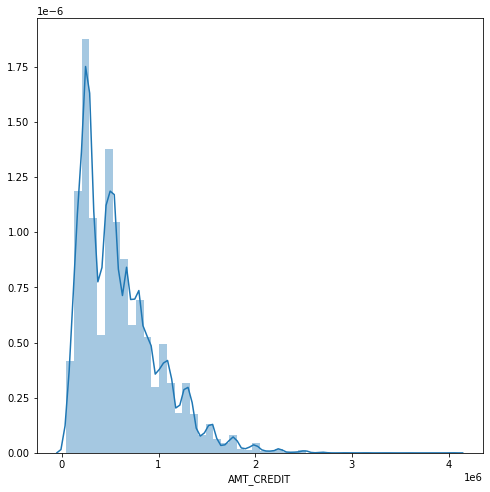

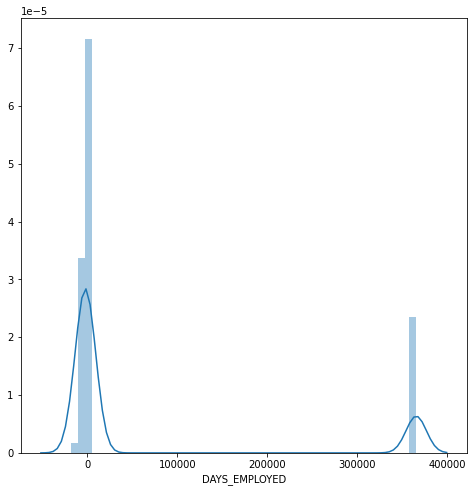

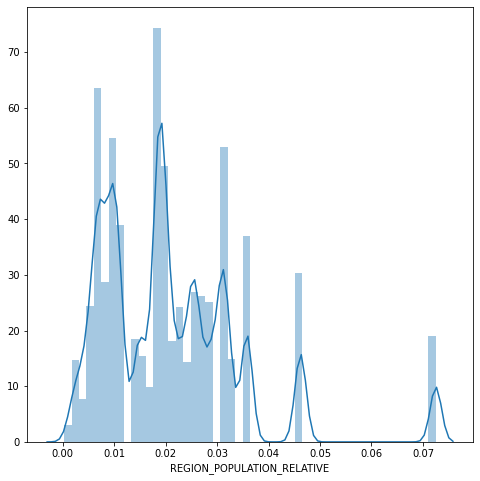

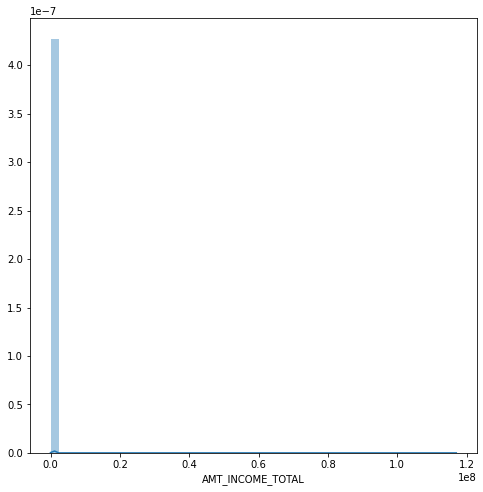

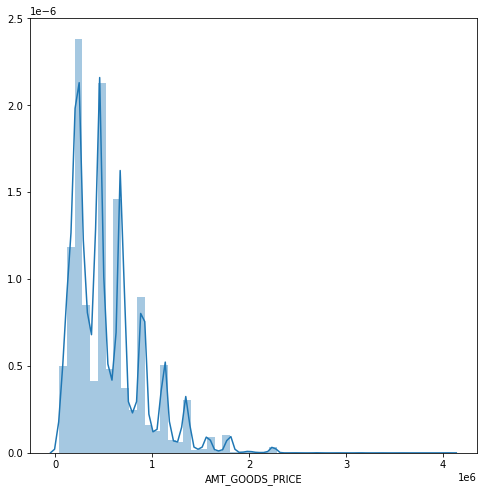

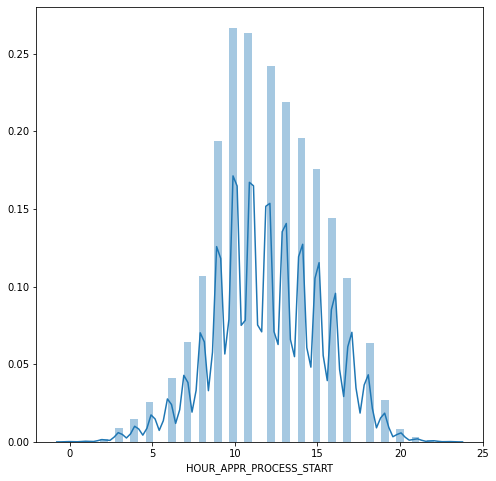

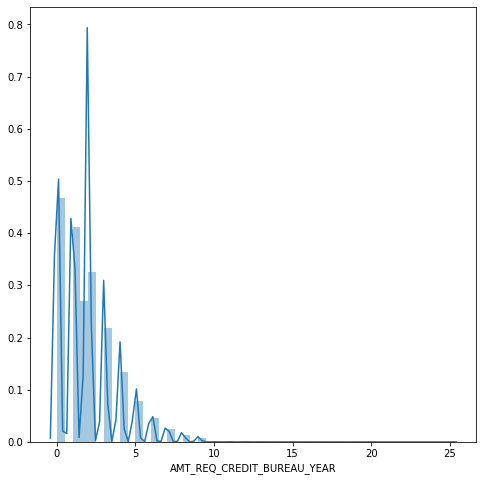

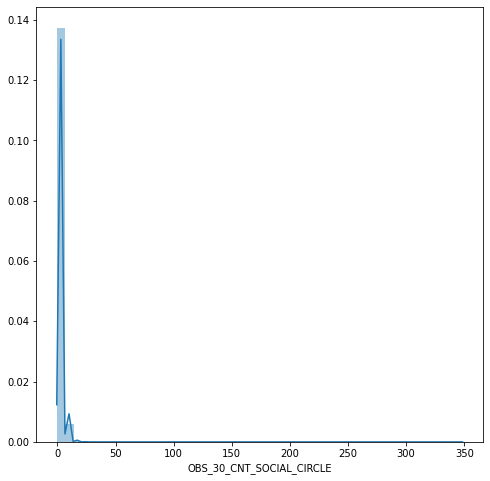

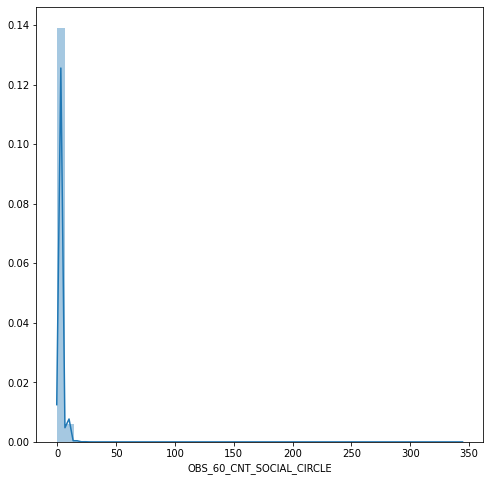

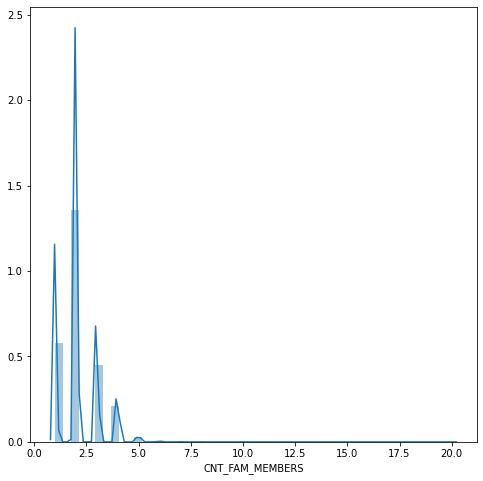

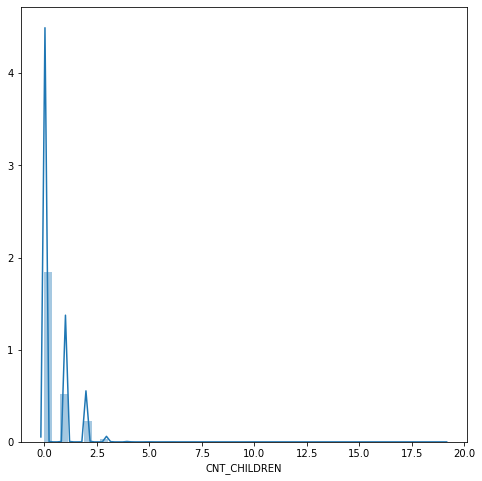

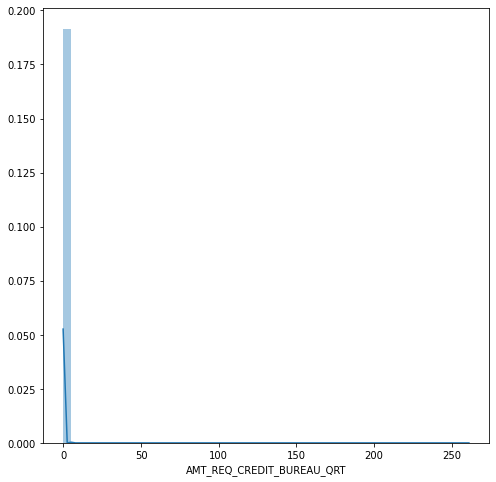

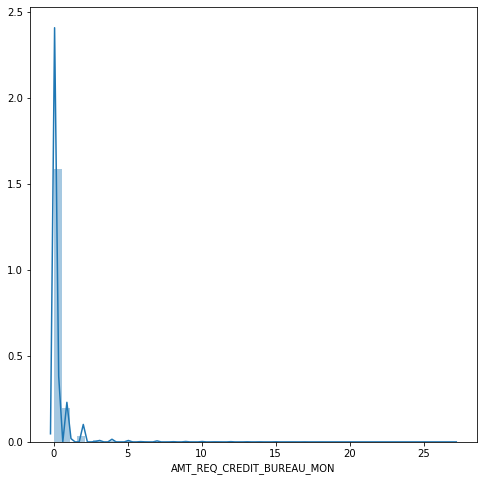

In [42]:
# 3.で選択した特徴量の分布を見て、必要に応じて対数変換・スケーリングを実施する
for column in list_selected_feature:
    plt.figure(figsize=(8, 8))
    sns.distplot(df_train_select1[column], bins=50)

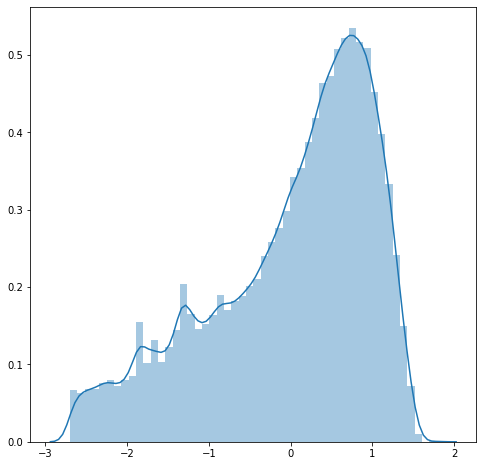

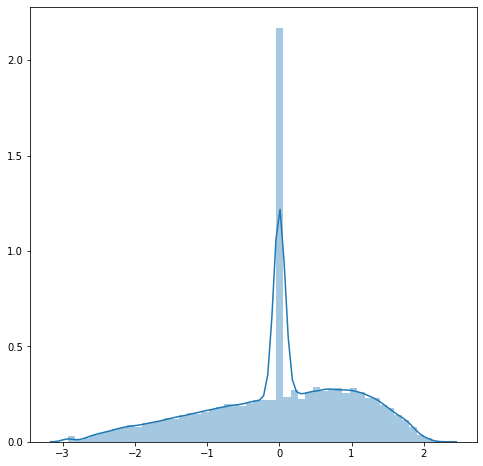

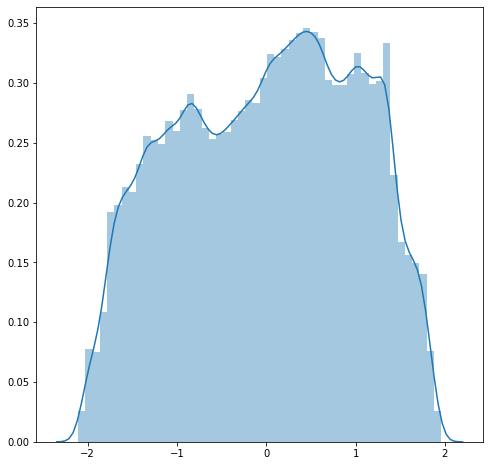

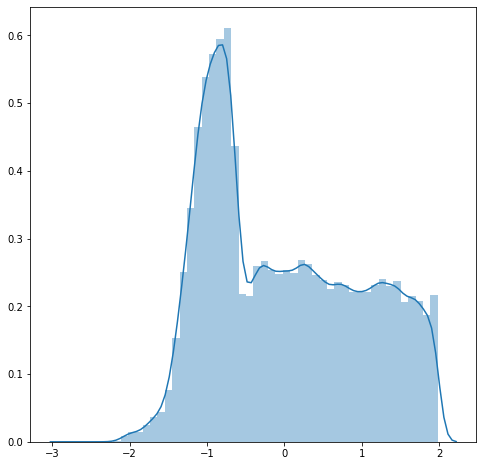

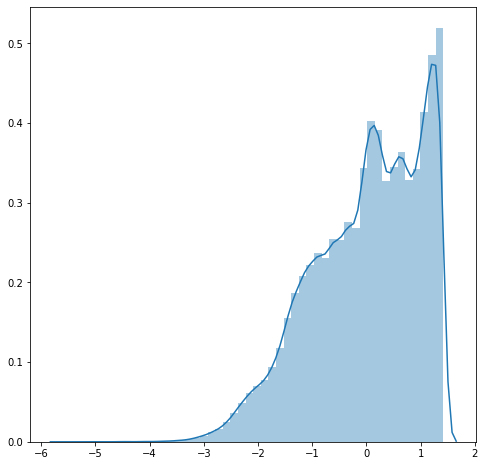

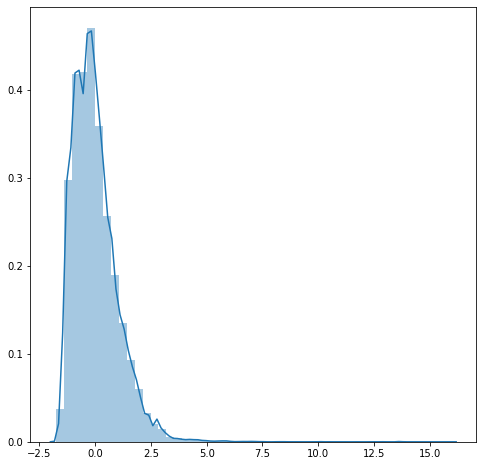

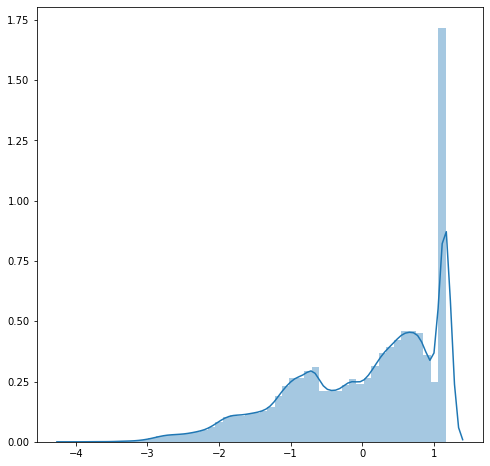

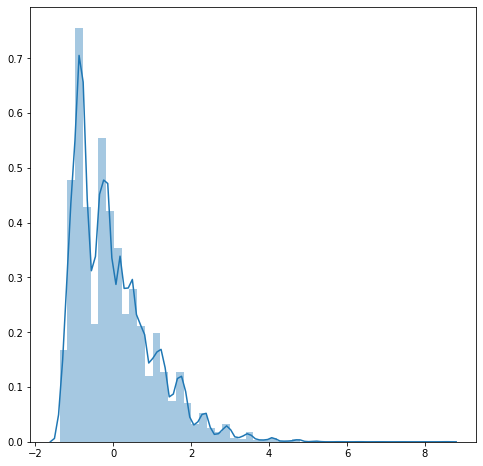

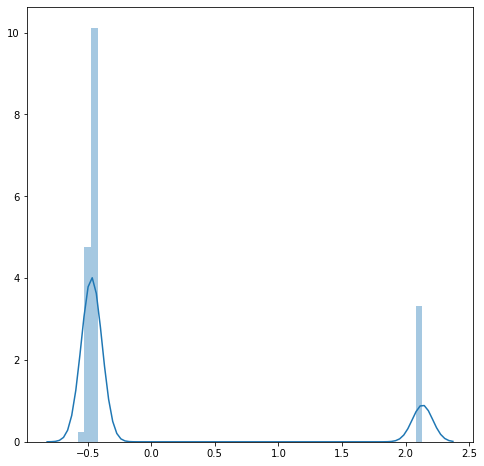

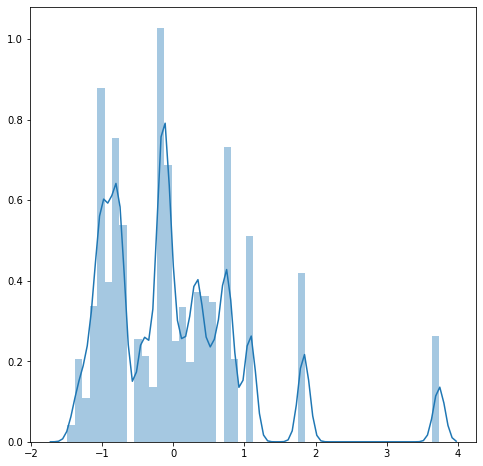

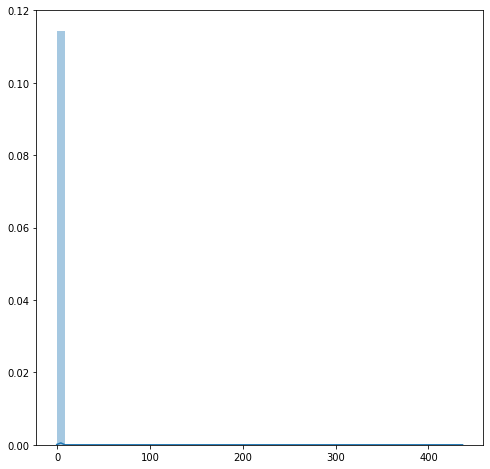

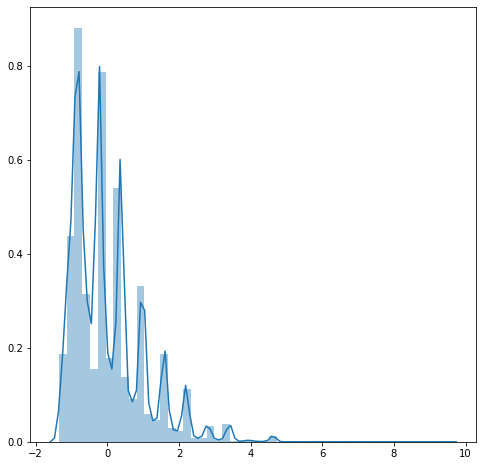

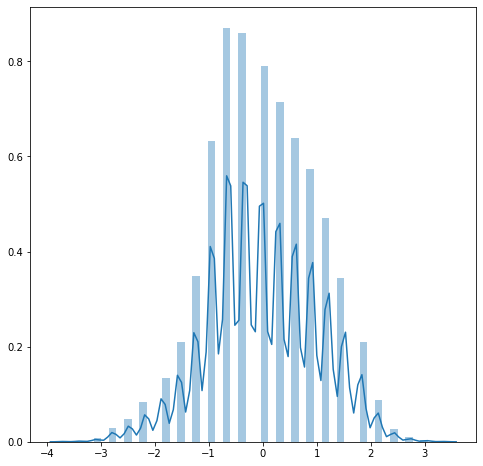

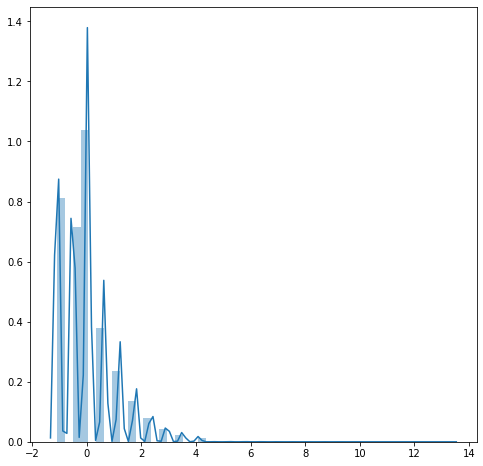

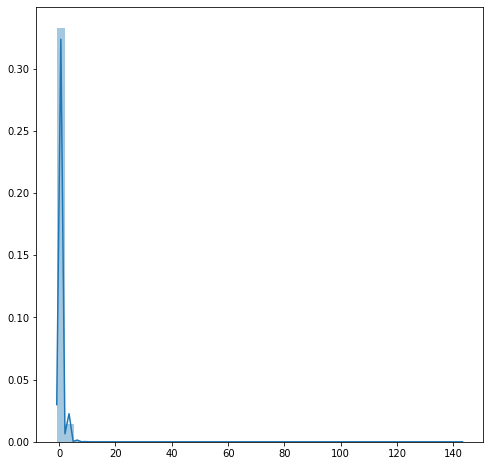

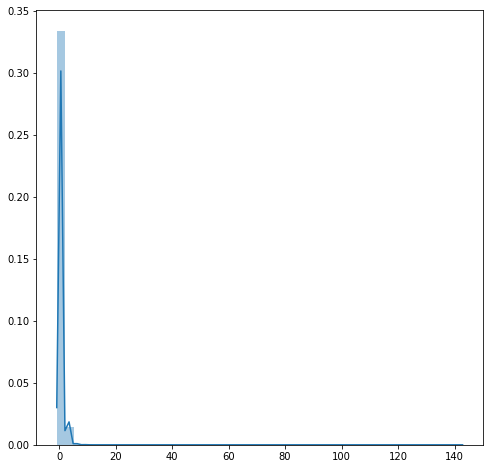

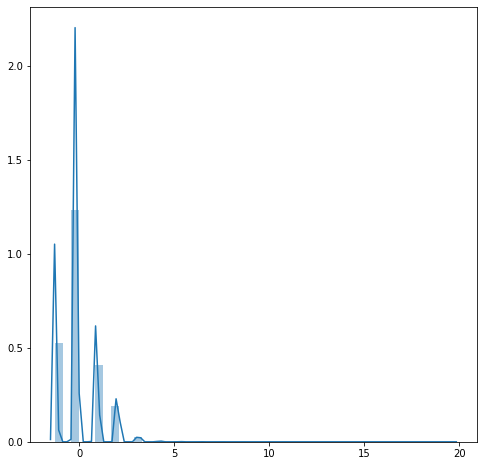

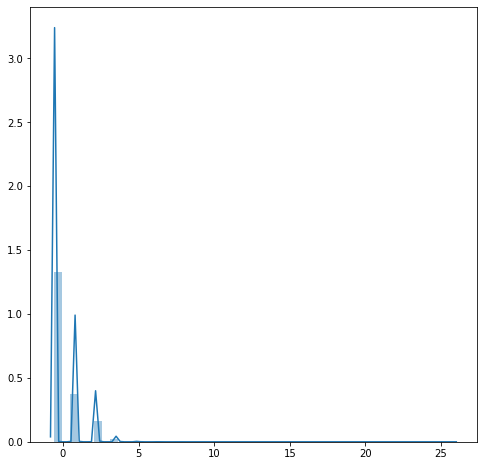

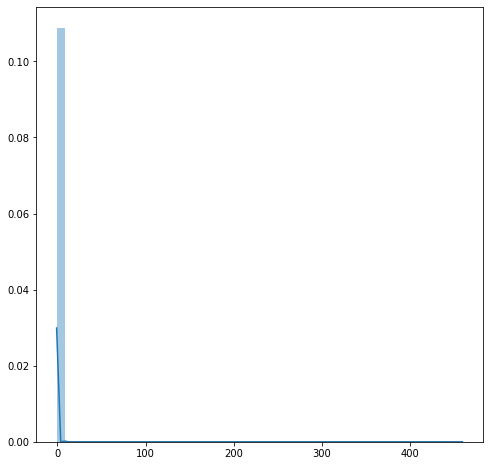

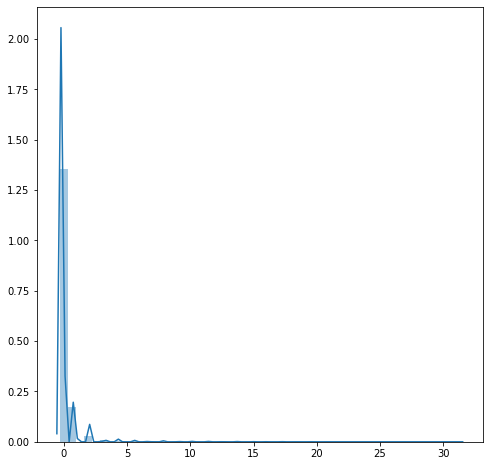

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

list_feature_name = df_train_select3.columns.drop(['SK_ID_CURR', 'TARGET'])

X = df_train_select3[list_feature_name]
y = df_train_select3['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=32)

scaler.fit(X_train[list_selected_feature])

X_train_select1_scaled = scaler.transform(df_train_select1[list_selected_feature])

for i, column in enumerate(list_selected_feature):
    plt.figure(figsize=(8, 8))
    sns.distplot(X_train_select1_scaled[:, i], bins=50)

In [44]:
df_train_scaled = pd.DataFrame(X_train_select1_scaled, columns=list_selected_feature)
X = pd.concat([df_train_scaled, 
              df_train_encode.loc[:, df_train_encode.columns.str.startswith('NAME_INCOME_TYPE')]],
              axis=1)
y = df_train_select3['TARGET']

dict_score = {}
for name, model in dict_model.items():
    dict_score[name] = dataSplit2calcScore(X, y, model)

pd.DataFrame(dict_score.values(), index=dict_score.keys()).rename(columns={0: 'ROC-AUC'})

,ROC-AUC
KNeighborsClassifier,0.587275
LogisticRegression,0.722652
DecisionTreeClassifier,0.530341
RandomForestClassifier,0.705849


#### 結果( 4. 3.で選択した特徴量の分布を見て、必要に応じて対数変換・スケーリングを実施する)
決定木・ランダムフォレストは指標値に大きな変化は見られなかったが、再近傍法・ロジスティック回帰は指標値が改善した。\
特にロジスティック回帰で著しい改善が見られ、最も優れたモデルとなった。シグモイド関数において説明変数の値が0を堺に出力が変わるため、正則化による影響が大きいと思われる。\
決定木・ランダムフォレストについては、各特徴量のスケールが変わったことでジニ不純度に影響すると思われる。\
改善・改悪するかはデータの分布の仕方や木の深さによるため、決定木アルゴリズムにおける正則化は実施したほうが良いかどうかは両方試さないと判断が難しい。

In [51]:
# 5.はスキップ
# 6. モデルのパラメータを変えながら検証する

# ハイパーパラメータをグリッドサーチする 
from sklearn.model_selection import GridSearchCV

# 再近傍法
knc = KNeighborsClassifier()
parameters_knc = {
#     'n_neighbors': [1, 3, 5, 7, 10],
    'n_neighbors': [10],
#     'weights': ['uniform', 'distance'],
    'weights': ['uniform'],
#     'p': [1, 2]
    'p': [2]
}
cv_knc = GridSearchCV(knc, parameters_knc)

# ロジスティック回帰
lr = LogisticRegression(max_iter=1000) # max_iterがデフォルトだと収束に関する警告が出る
parameters_lr = {
#     'penalty': ['l1', 'l2', 'elasticnet'],
    'penalty': ['l2'],
#     'dual': [False, True],
    'dual': [True],
#     'C' : [0.001, 0.01, 0.1, 1, 10, 100],
    'C' : [100],
#     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    'solver': ['liblinear']
}
cv_lr = GridSearchCV(lr, parameters_lr)

# 決定木
dt = DecisionTreeClassifier()
parameters_dt = {
#     'criterion': ['gini', 'entropy'],
#     'splitter': ['best', 'random'],
    'max_depth': [i for i in range(1, 11)],
#     'min_samples_split': [i for i in range(2, 11)],
#     'min_samples_leaf': [i for i in range(1, 11)],
#     'random_state': [i for i in range(0, 101)]
}
cv_dt = GridSearchCV(dt, parameters_dt)

# ランダムフォレスト
rf = RandomForestClassifier()
parameters_rf = {
    'max_depth': [i for i in range(1, 11)],
    'n_estimators':[10, 20, 30, 40, 50, 100, 200, 300, 400, 500],
    'max_features': [1, 3, 10],
#     'min_samples_split': [i for i in range(2, 11)],
#     'min_samples_leaf': [i for i in range(1, 11)],
#     'bootstrap': [True, False],
#     'criterion': ['gini', 'entropy']
}
cv_rf = GridSearchCV(rf, parameters_rf)

dict_model_2 = {
    "KNeighborsClassifier":cv_knc,
    "LogisticRegression":cv_lr,
    "DecisionTreeClassifier":cv_dt,
    "RandomForestClassifier":cv_rf
}

In [50]:
import logging # loggingの練習

formatter = '%(levelname)s : %(asctime)s : %(message)s'
logging.basicConfig(filename='Logger.log', level=logging.DEBUG, format=formatter)

logging.debug('TEST')
logging.info("%s %s", {"test":0, "test2":3}, [3, 5, 7])
logging.info("%s", {"test":0, "test2":3})

In [52]:
df_train_scaled = pd.DataFrame(X_train_select1_scaled, columns=list_selected_feature)
X = pd.concat([df_train_scaled, 
              df_train_encode.loc[:, df_train_encode.columns.str.startswith('NAME_INCOME_TYPE')]],
              axis=1)
y = df_train_select3['TARGET']

dict_score = {}
for name, model in dict_model_2.items():
    logging.debug('[start]%s', name)
    dict_model_2[name] = dataSplit2calcScore(X, y, model)
    logging.info('%s:Best_params:%s', name, model.best_params_)    
    logging.debug('[end]%s', name)

pd.DataFrame(dict_score.values(), index=dict_score.keys()).rename(columns={0: 'ROC-AUC'})

/home/timanishi/.pyenv/versions/3.7.8/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/timanishi/.pyenv/versions/3.7.8/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/timanishi/.pyenv/versions/3.7.8/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/timanishi/.pyenv/versions/3.7.8/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/timanishi/.pyenv/versions/3.7.8/lib/python3.7/site-packages/sklearn/svm/_base.py:9

""


Logger.logから一部抜粋(2020/8/3 11:30現在)
```
DEBUG : 2020-08-01 10:23:00,733 : [start]KNeighborsClassifier
INFO : 2020-08-01 21:51:54,179 : KNeighborsClassifier:Best_params:{'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}
DEBUG : 2020-08-01 21:51:54,179 : [end]KNeighborsClassifier
DEBUG : 2020-08-01 21:51:54,179 : [start]LogisticRegression
INFO : 2020-08-02 01:00:16,381 : LogisticRegression:Best_params:{'C': 100, 'dual': True, 'penalty': 'l2', 'solver': 'liblinear'}
DEBUG : 2020-08-02 01:00:16,381 : [end]LogisticRegression
DEBUG : 2020-08-02 01:00:16,381 : [start]DecisionTreeClassifier
```
決定木が終わる気配がないので、パラメータを減らしてグリッドサーチを実施。すでに完了したロジスティック回帰・再近傍法は最良値を設定するようにする。


```
DEBUG : 2020-08-03 11:33:14,457 : [start]KNeighborsClassifier
INFO : 2020-08-03 12:12:39,185 : KNeighborsClassifier:Best_params:{'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}
DEBUG : 2020-08-03 12:12:39,185 : [end]KNeighborsClassifier
DEBUG : 2020-08-03 12:12:39,185 : [start]LogisticRegression
INFO : 2020-08-03 12:18:14,970 : LogisticRegression:Best_params:{'C': 100, 'dual': True, 'penalty': 'l2', 'solver': 'liblinear'}
DEBUG : 2020-08-03 12:18:14,970 : [end]LogisticRegression
DEBUG : 2020-08-03 12:18:14,970 : [start]DecisionTreeClassifier
INFO : 2020-08-03 12:19:00,621 : DecisionTreeClassifier:Best_params:{'max_depth': 1}
DEBUG : 2020-08-03 12:19:00,621 : [end]DecisionTreeClassifier
DEBUG : 2020-08-03 12:19:00,622 : [start]RandomForestClassifier
INFO : 2020-08-03 20:59:10,956 : RandomForestClassifier:Best_params:{'max_depth': 9, 'max_features': 10, 'n_estimators': 300}
DEBUG : 2020-08-03 20:59:10,956 : [end]RandomForestClassifier
```

辞書は今のノートブックの状態で実施。ランダムフォレストに時間がかかった。\
また、ライブラリの使い方を間違えていたので、ログに出ているパラメータでもう一度だけ実施。

In [73]:
knc_3 = KNeighborsClassifier(n_neighbors=10, p=2, weights='uniform')
lr_3 = LogisticRegression(max_iter=1000, C=100, dual=True, penalty='l2', solver='liblinear') # max_iterがデフォルトだと収束に関する警告が出る
dt_3 = DecisionTreeClassifier(max_depth=1)
rf_3 = RandomForestClassifier(max_depth=9, max_features=10, n_estimators=300)

dict_model_3 = {
    "KNeighborsClassifier":knc_3,
    "LogisticRegression":lr_3,
    "DecisionTreeClassifier":dt_3,
    "RandomForestClassifier":rf_3
}

df_train_scaled = pd.DataFrame(X_train_select1_scaled, columns=list_selected_feature)
X = pd.concat([df_train_scaled, 
              df_train_encode.loc[:, df_train_encode.columns.str.startswith('NAME_INCOME_TYPE')]],
              axis=1)
y = df_train_select3['TARGET']

In [66]:
X.columns

Index(['EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH',
       'DAYS_REGISTRATION', 'AMT_ANNUITY', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_CREDIT', 'DAYS_EMPLOYED', 'REGION_POPULATION_RELATIVE',
       'AMT_INCOME_TOTAL', 'AMT_GOODS_PRICE', 'HOUR_APPR_PROCESS_START',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'CNT_FAM_MEMBERS', 'CNT_CHILDREN',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_MON',
       'NAME_INCOME_TYPE_Commercial associate',
       'NAME_INCOME_TYPE_Maternity leave', 'NAME_INCOME_TYPE_Pensioner',
       'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student',
       'NAME_INCOME_TYPE_Unemployed', 'NAME_INCOME_TYPE_Working'],
      dtype='object')

In [56]:
dict_score_3 = {}
for name, model in dict_model_3.items():
    dict_score_3[name] = dataSplit2calcScore(X, y, model)

pd.DataFrame(dict_score_3.values(), index=dict_score_3.keys()).rename(columns={0: 'ROC-AUC'})

/home/timanishi/.pyenv/versions/3.7.8/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,ROC-AUC
KNeighborsClassifier,0.619402
LogisticRegression,0.723486
DecisionTreeClassifier,0.587389
RandomForestClassifier,0.727626


#### 結果( 6. モデルのパラメータを変えながら検証する)
全てのモデルで指標値が改善した。特に、再近傍法・決定木の指標値の改善幅が大きい。\
[前回]
- KNeighborsClassifier:0.587275
- LogisticRegression:0.722652
- DecisionTreeClassifier:0.530341
- RandomForestClassifier:0.705849

今回のグリッドサーチはモデルの仕組みを理解しないまま当てずっぽうで辞書を作成した。\
そのため、処理に時間がかかり諦めたパターンもいくつか存在する。試したいパラメータのみをグリッドサーチにかけられるようになりたい。

Kaggelに提出するためのデータを作成する。今回は一番指標値が良かったランダムフォレストのモデルで実施する。

In [75]:
df_train_scaled = pd.DataFrame(X_train_select1_scaled, columns=list_selected_feature)
X = pd.concat([df_train_scaled, 
              df_train_encode.loc[:, df_train_encode.columns.str.startswith('NAME_INCOME_TYPE')]],
              axis=1)
y = df_train_select3['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=32)
rf_3.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, max_features=10, n_estimators=300)

In [76]:
df_test_encode = trans_qualitative(df_test_drop, dict_kind_column, list_dict_map)
df_test_select1 = pd.concat([df_test_encode[['SK_ID_CURR']], df_test_encode[list_selected_feature]], axis=1)
df_test_select3 = pd.concat([df_test_select1, 
                             df_test_encode.loc[:, df_test_encode.columns.str.startswith('NAME_INCOME_TYPE')]],
                             axis=1)
X_test_select1_scaled = scaler.transform(df_test_select1[list_selected_feature])
df_test_scaled = pd.DataFrame(X_test_select1_scaled, columns=list_selected_feature)
df_test_edited = pd.concat([df_test_scaled, 
                            df_test_encode.loc[:, df_test_encode.columns.str.startswith('NAME_INCOME_TYPE')]],
                            axis=1)

In [77]:
df_test_edited.columns

Index(['EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH',
       'DAYS_REGISTRATION', 'AMT_ANNUITY', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_CREDIT', 'DAYS_EMPLOYED', 'REGION_POPULATION_RELATIVE',
       'AMT_INCOME_TOTAL', 'AMT_GOODS_PRICE', 'HOUR_APPR_PROCESS_START',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'CNT_FAM_MEMBERS', 'CNT_CHILDREN',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_MON',
       'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Pensioner',
       'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student',
       'NAME_INCOME_TYPE_Unemployed', 'NAME_INCOME_TYPE_Working'],
      dtype='object')

テストデータに"NAME_INCOME_TYPE_Maternity leave"が無いらしいので追加する。

In [78]:
df_test_edited["NAME_INCOME_TYPE_Maternity leave"] = 0
df_test_edited

,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_REGISTRATION,AMT_ANNUITY,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT,DAYS_EMPLOYED,REGION_POPULATION_RELATIVE,...,CNT_CHILDREN,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_MON,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_Maternity leave
0,1.443376,-2.015809,-0.734548,1.442929,-0.051799,-0.453018,-0.939065,-0.077475,-0.468331,-0.144308,...,-0.578225,-0.463740,-0.313830,0,0,0,0,0,1,0
1,-1.168335,-0.446458,-0.464909,0.906103,-1.172708,-0.673228,1.165272,-0.936175,-0.483475,1.081277,...,-0.578225,-0.463740,-0.313830,0,0,0,0,0,1,0
2,0.972074,0.575299,-0.917132,-0.338329,0.798537,2.943935,0.130035,0.156944,-0.483397,-0.126151,...,-0.578225,1.295677,-0.313830,0,0,0,0,0,1,0
3,-0.024940,0.585130,0.471609,-0.804990,0.848222,1.511171,-1.017675,2.419473,-0.465054,0.401280,...,2.194720,-0.463740,-0.313830,0,0,0,0,0,1,0
4,-0.465417,-0.061102,0.686037,-0.840735,0.280386,0.341168,0.172364,0.063230,-0.467354,-0.782203,...,0.808247,0.498489,-0.302944,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,0.703497,0.759151,-0.901554,-0.269488,-1.165894,-0.666084,0.338050,-0.465194,-0.488429,-1.360200,...,-0.578225,-0.463740,-0.313830,0,0,0,0,0,1,0
48740,0.892405,-0.061102,1.110769,-0.007363,0.560045,0.330297,1.165272,0.055569,-0.459980,1.081277,...,2.194720,0.498489,-0.302944,1,0,0,0,0,0,0
48741,0.620607,-1.303039,0.025801,0.984872,0.654874,0.419748,0.151804,-0.707295,-0.473341,0.401280,...,0.808247,4.814511,-0.313830,1,0,0,0,0,0,0
48742,-0.360457,0.486139,0.473442,1.077543,1.001254,-0.137766,-1.625998,-0.372284,-0.471175,-0.144308,...,-0.578225,-0.463740,-0.313830,1,0,0,0,0,0,0


In [82]:
y_pred_sub = rf_3.predict_proba(df_test_edited)
y_pred_sub[:, 1]

array([0.11729308, 0.13400356, 0.06027154, ..., 0.10015107, 0.05182002,
       0.14579415])

In [83]:
score_submit_2 = pd.concat([df_test['SK_ID_CURR'], pd.Series(y_pred_sub[:, 1])], axis=1)
score_submit_2 = score_submit_2.rename(columns={0: 'TARGET'})
score_submit_2

,SK_ID_CURR,TARGET
0,100001,0.117293
1,100005,0.134004
2,100013,0.060272
3,100028,0.044083
4,100038,0.108448
...,...,...
48739,456221,0.047991
48740,456222,0.058308
48741,456223,0.100151
48742,456224,0.051820


In [84]:
score_submit_2.to_csv('kaggle_2.csv', index=False)

- Private Score:0.69647
- Public Score:0.70473